In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as at
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler as SS
from sklearn.cluster import KMeans


In [ ]:
!wget https://raw.githubusercontent.com/namespaiva/pi-acidentes/refs/heads/main/dados/acidentes.csv

--2024-11-27 15:24:14--  https://raw.githubusercontent.com/namespaiva/pi-acidentes/refs/heads/main/dados/acidentes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4697579 (4.5M) [text/plain]
Saving to: ‘acidentes.csv’

acidentes.csv       100%[===================>]   4.48M  9.34MB/s    in 0.5s    

2024-11-27 15:24:16 (9.34 MB/s) - ‘acidentes.csv’ saved [4697579/4697579]



In [ ]:
data = pd.read_csv('acidentes.csv')

data["data"] = pd.to_datetime(data["data"], errors="coerce")
data = data[data["data"].dt.year >= 2018].copy()

# data["gravidade"] = data["gravidade"].apply(lambda s: 1 if s != "S/ LESÃO" else 0)
data = data[["lat","lng"]].sample(2000).copy()

scaler = SS()

data["lat"] = scaler.fit_transform(data["lat"].values.reshape(-1,1))
data["lng"] = scaler.fit_transform(data["lng"].values.reshape(-1,1))

In [ ]:
coords = {'features': data.columns}

In [ ]:
with pm.Model() as dpmm_model:
    cluster_size = 10
    alpha = pm.Gamma("alpha", 1.0, 1.0)

    weights = pm.Dirichlet("weights", a=alpha * pm.math.ones(cluster_size))

    mu = pm.Normal("mu", 0, 1, shape=(cluster_size, 2))
    sigma = pm.HalfNormal("sigma", 1, shape=(cluster_size, 2))

    components = [pm.MvNormal.dist(mu[i], at.diag(sigma[i])) for i in range(cluster_size)]

    mixture = pm.Mixture("mixture", w=weights, comp_dists=components, observed=data[["lat", "lng"]].values)

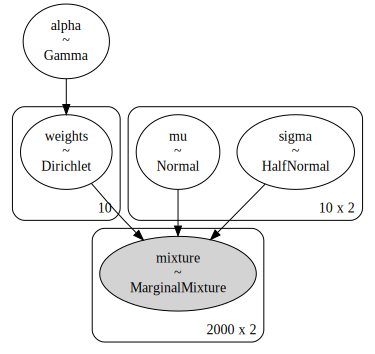

In [ ]:
pm.model_to_graphviz(dpmm_model)

In [ ]:
with dpmm_model:
    approx = pm.fit()

Output()

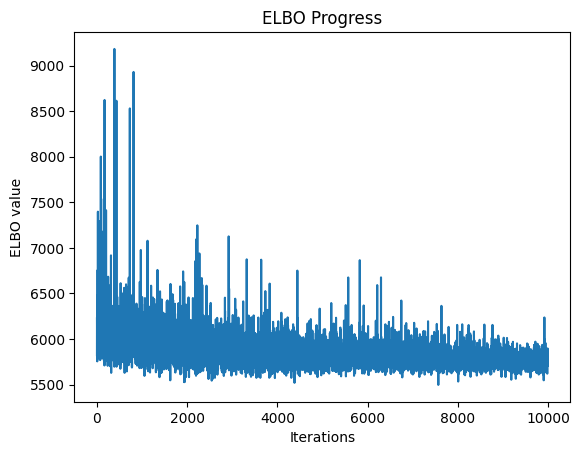

In [ ]:
plt.plot(approx.hist)
plt.title('ELBO Progress')
plt.xlabel('Iterations')
plt.ylabel('ELBO value')
plt.show()


In [ ]:
with dpmm_model:
    trace = approx.sample()

In [ ]:
pm.summary(trace)

Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.672,0.756,0.521,3.080,0.034,0.024,488.0,473.0,NaN
"mu[0, 0]",-0.046,0.381,-0.799,0.642,0.017,0.012,486.0,488.0,NaN
"mu[0, 1]",0.067,0.334,-0.502,0.704,0.015,0.011,502.0,444.0,NaN
"mu[1, 0]",-0.183,0.400,-0.881,0.574,0.019,0.014,437.0,449.0,NaN
"mu[1, 1]",0.211,0.351,-0.376,0.931,0.017,0.012,446.0,438.0,NaN
"mu[2, 0]",0.057,0.392,-0.609,0.843,0.019,0.015,439.0,319.0,NaN
"mu[2, 1]",-0.066,0.366,-0.743,0.605,0.017,0.012,492.0,454.0,NaN
"mu[3, 0]",0.214,0.420,-0.569,1.009,0.022,0.015,395.0,373.0,NaN
"mu[3, 1]",-0.218,0.374,-0.870,0.487,0.019,0.013,392.0,434.0,NaN
"mu[4, 0]",-0.187,0.385,-0.852,0.491,0.017,0.012,511.0,331.0,NaN


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'weights'}>,
        <Axes: title={'center': 'weights'}>]], dtype=object)

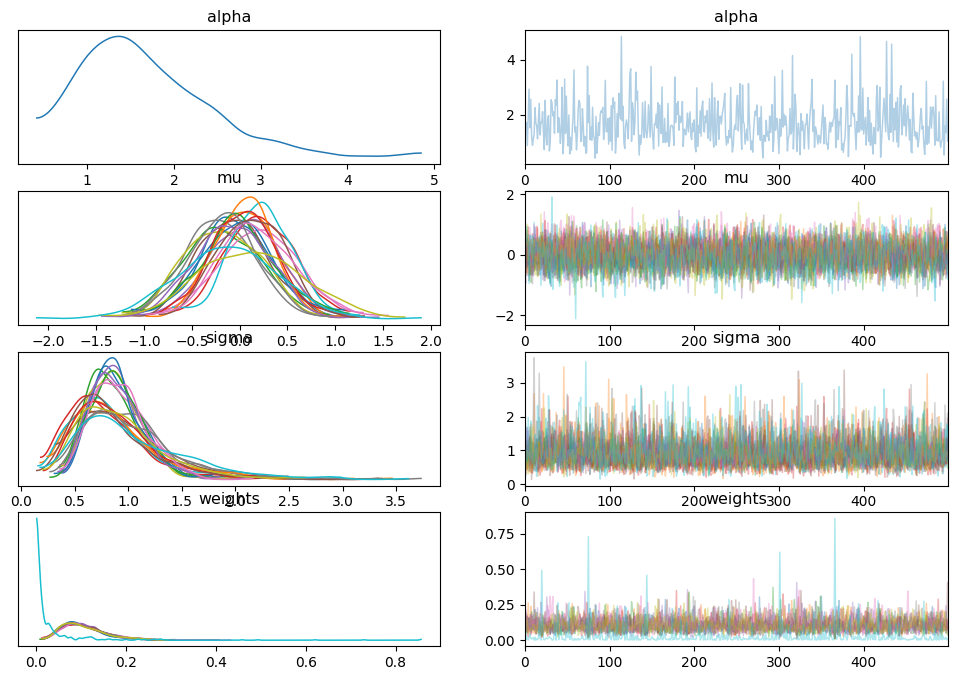

In [ ]:
az.plot_trace(trace)

In [ ]:
with dpmm_model:
    ppc = pm.sample_posterior_predictive(trace)

Output()

<Axes: xlabel='mixture'>

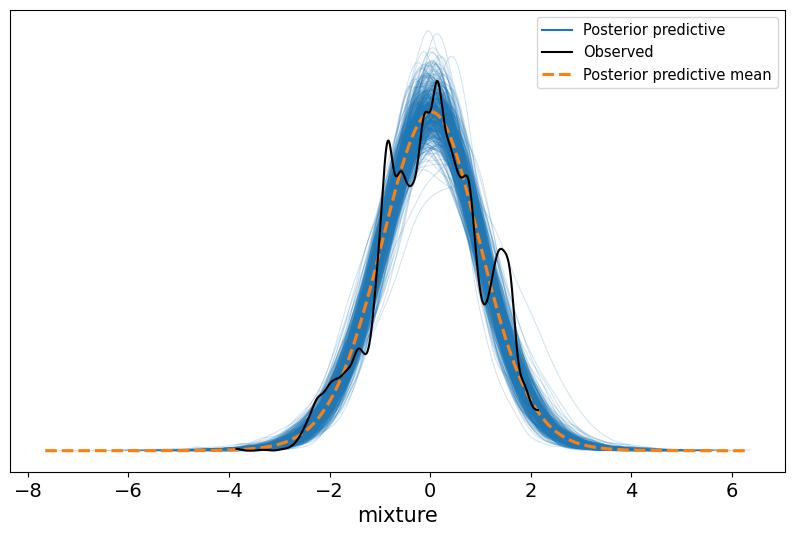

In [ ]:
az.plot_ppc(ppc, mean=True, figsize=(10, 6), textsize=14)

In [ ]:
g_samples = ppc.posterior_predictive["mixture"]

In [ ]:
mean_predictions = g_samples.mean(dim=('chain', 'draw')).values

clusters = np.argmax(mean_predictions, axis=1)

clusters

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
data["cluster"] = clusters
data.to_csv("nome_do_arquivo.csv", index=False)

In [ ]:
dfbayesiano = pd.read_csv('nome_do_arquivo.csv')


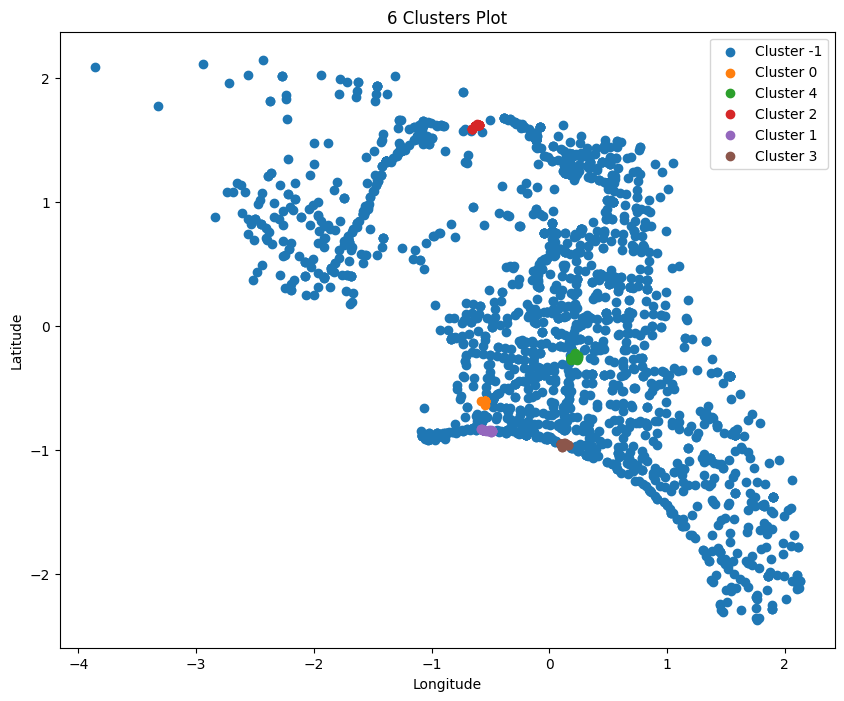

In [ ]:

plt.figure(figsize=(10, 8))
for cluster in dfbayesiano['cluster'].unique():
    subset = dfbayesiano[dfbayesiano['cluster'] == cluster]
    plt.scatter(subset['lng'], subset['lat'], label=f'Cluster {cluster}')
plt.title('6 Clusters Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Cruzamentos com mais acidentes:

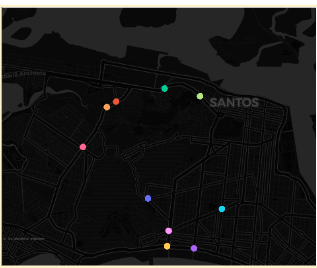